Трансферное обучение. Используя предобученные нейронные сети для задачи классификации изображений подобрать модель таким образом что бы метрики качества были максимальны. 
Вывести графики обучения. Проанализировать результат. Использовать колллбеки для изменения скорости обучения и сохранения лучшей модели. Использовать набор данных с EuroSat
В ГИТ модель не пихать!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt


ResNet-50 (обучаются последние 3 слоя)

d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.3554
Test Accuracy: 95.87%
Best model saved!


Epoch [2/10], Loss: 0.1760
Test Accuracy: 96.28%
Best model saved!


Epoch [3/10], Loss: 0.1127
Test Accuracy: 96.37%
Best model saved!


Epoch [4/10], Loss: 0.0990
Test Accuracy: 96.13%


Epoch [5/10], Loss: 0.0732
Test Accuracy: 95.91%


Epoch [6/10], Loss: 0.0808
Test Accuracy: 95.91%


Epoch [7/10], Loss: 0.0517
Test Accuracy: 95.61%


Epoch [8/10], Loss: 0.0494
Test Accuracy: 95.76%


Epoch [9/10], Loss: 0.0390
Test Accuracy: 95.69%


Epoch [10/10], Loss: 0.0447
Test Accuracy: 95.70%


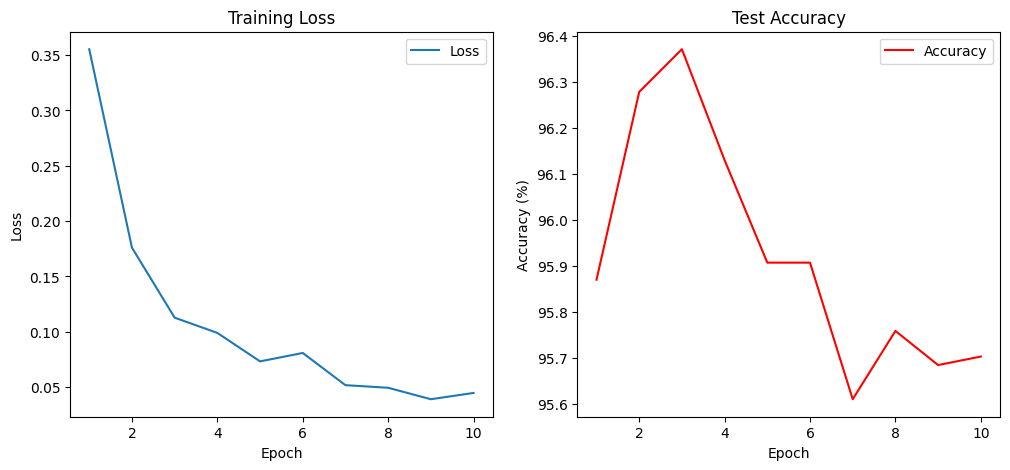

In [42]:
# Гиперпараметры
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 10  # Измените в зависимости от числа классов в вашей папке
DATA_DIR = "EuroSAT/2750"  # Путь к директории с изображениями
TRAIN_RATIO = 0.8  # 80% обучающая выборка, 20% тестовая

# Аугментация и нормализация
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Загрузка полного датасета
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Создание модели ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        
        # Замораживаем все слои, кроме последних 3
        for name, param in self.model.named_parameters():
            if not ("layer3" in name or "layer4" in name or "fc" in name):
                param.requires_grad = False
        
        # Заменяем последний слой
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Инициализация модели
model = ResNet50Classifier(NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Колбэк для сохранения лучшей модели
best_accuracy = 0.0
losses = []
accuracies = []

# Обучение
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_loader))
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")
    
    # Оценка на тестовых данных
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Обновление learning rate
    scheduler.step(epoch_loss)
    
    # Сохранение лучшей модели
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_resnet_model.pth")
        print("Best model saved!")

# Визуализация графиков обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), accuracies, label='Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()



ResNet-50 (обучаются все слои)

Epoch [1/10], Loss: 0.3852
Test Accuracy: 95.24%
Best model saved!


Epoch [2/10], Loss: 0.1573
Test Accuracy: 96.65%
Best model saved!


Epoch [3/10], Loss: 0.1170
Test Accuracy: 95.69%


Epoch [4/10], Loss: 0.0919
Test Accuracy: 96.11%


Epoch [5/10], Loss: 0.0807
Test Accuracy: 96.39%


Epoch [6/10], Loss: 0.0622
Test Accuracy: 96.13%


Epoch [7/10], Loss: 0.0566
Test Accuracy: 96.44%


Epoch [8/10], Loss: 0.0486
Test Accuracy: 96.50%


Epoch [9/10], Loss: 0.0408
Test Accuracy: 95.70%


Epoch [10/10], Loss: 0.0430
Test Accuracy: 95.43%


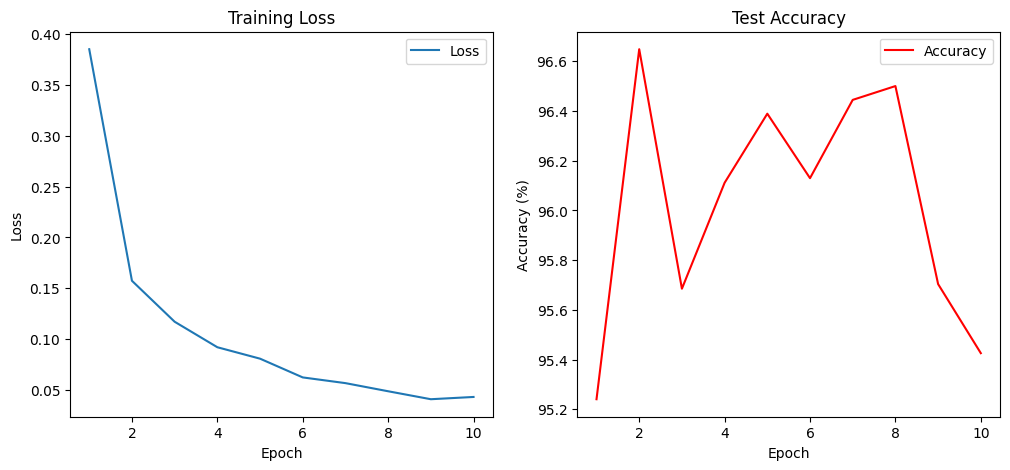

In [43]:
# Гиперпараметры
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 10  # Число классов
DATA_DIR = "EuroSAT/2750"  # Путь к директории с изображениями
TRAIN_RATIO = 0.8  # 80% обучающая выборка, 20% тестовая

# Аугментация и нормализация
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Загрузка полного датасета
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Создание модели ResNet средней толщины (ResNet-50)
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Инициализация модели
model = ResNet50Classifier(NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Колбэк для сохранения лучшей модели
best_accuracy = 0.0
losses = []
accuracies = []

# Обучение
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_loader))
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")
    
    # Оценка на тестовых данных
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Обновление learning rate
    scheduler.step(epoch_loss)
    
    # Сохранение лучшей модели
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_resnet_model.pth")
        print("Best model saved!")

# Визуализация графиков обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), accuracies, label='Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()


EfficientNet-B3 (обучаются 3 последних слоя)

d:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\Python\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Loss: 0.5468
Test Accuracy: 89.91%
Best model saved!


Epoch [2/10], Loss: 0.2609
Test Accuracy: 93.67%
Best model saved!


Epoch [3/10], Loss: 0.2064
Test Accuracy: 94.35%
Best model saved!


Epoch [4/10], Loss: 0.1702
Test Accuracy: 93.26%


Epoch [5/10], Loss: 0.1347
Test Accuracy: 94.69%
Best model saved!


Epoch [6/10], Loss: 0.1230
Test Accuracy: 94.15%


Epoch [7/10], Loss: 0.1061
Test Accuracy: 94.06%


Epoch [8/10], Loss: 0.1041
Test Accuracy: 94.54%


Epoch [9/10], Loss: 0.0885
Test Accuracy: 93.81%


Epoch [10/10], Loss: 0.0821
Test Accuracy: 94.35%


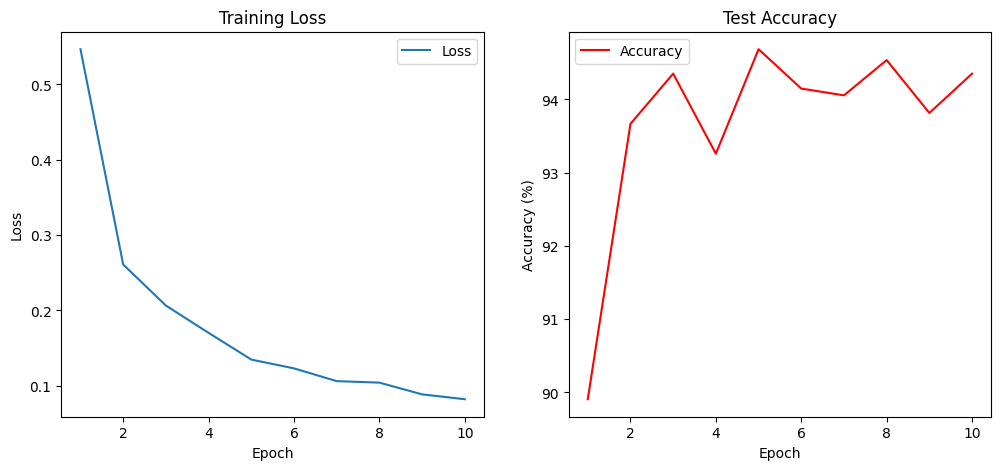

In [ ]:
# Гиперпараметры
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 10  # Измените в зависимости от числа классов в вашей папке
DATA_DIR = "EuroSAT/2750"  # Путь к директории с изображениями
TRAIN_RATIO = 0.8  # 80% обучающая выборка, 20% тестовая

# Аугментация и нормализация
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Загрузка полного датасета
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Создание модели EfficientNet-B3
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetClassifier, self).__init__()
        self.model = models.efficientnet_b3(pretrained=True)
        
        # Замораживаем все слои, кроме последних 3
        for name, param in self.model.named_parameters():
            if not ("features.6" in name or "features.7" in name or "classifier" in name):
                param.requires_grad = False
        
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Инициализация модели
model = EfficientNetClassifier(NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Колбэк для сохранения лучшей модели
best_accuracy = 0.0
losses = []
accuracies = []

# Обучение
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_loader))
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")
    
    # Оценка на тестовых данных
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Обновление learning rate
    scheduler.step(epoch_loss)
    
    # Сохранение лучшей модели
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")

# Визуализация графиков обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), accuracies, label='Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()



EfficientNet-B3 (обучаются все слои)

Epoch [1/10], Loss: 0.4145
Test Accuracy: 94.20%
Best model saved!


Epoch [2/10], Loss: 0.1646
Test Accuracy: 96.35%
Best model saved!


Epoch [3/10], Loss: 0.1159
Test Accuracy: 97.46%
Best model saved!


Epoch [4/10], Loss: 0.1037
Test Accuracy: 96.50%


Epoch [5/10], Loss: 0.0923
Test Accuracy: 96.67%


Epoch [6/10], Loss: 0.0854
Test Accuracy: 96.13%


Epoch [7/10], Loss: 0.0745
Test Accuracy: 93.57%


Epoch [8/10], Loss: 0.0622
Test Accuracy: 97.02%


Epoch [9/10], Loss: 0.0626
Test Accuracy: 97.17%


Epoch [10/10], Loss: 0.0577
Test Accuracy: 97.67%
Best model saved!


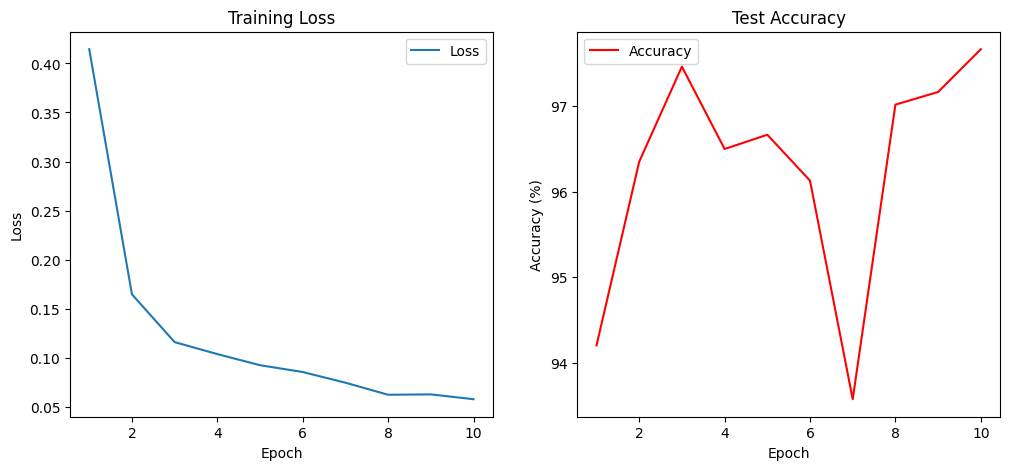

In [41]:
# Гиперпараметры
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 10  # Число классов
DATA_DIR = "EuroSAT/2750"   # Путь к директории с изображениями
TRAIN_RATIO = 0.8  # 80% обучающая выборка, 20% тестовая

# Аугментация и нормализация
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Загрузка полного датасета
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Создание модели EfficientNet средней толщины (EfficientNet-B3)
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetClassifier, self).__init__()
        self.model = models.efficientnet_b3(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

# Инициализация модели
model = EfficientNetClassifier(NUM_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оптимизатор и функция потерь
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Колбэк для сохранения лучшей модели
best_accuracy = 0.0
losses = []
accuracies = []

# Обучение
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_loader))
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")
    
    # Оценка на тестовых данных
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Обновление learning rate
    scheduler.step(epoch_loss)
    
    # Сохранение лучшей модели
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")

# Визуализация графиков обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), accuracies, label='Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()

В ходе работы дообучены на своих данных модели ResNet-50 и EfficientNet-B3. При этом выполнено обучение как последних 3 слоев моделей, так и моделей целиком. Получены следующие результаты (везде показатель метрики accuracy):
 - ResNet-50 (обучаются последние 3 слоя): 96.37%
 - ResNet-50 (обучаются все слои): 96.65%
 - EfficientNet-B3 (обучаются последние 3 слоя): 94.69 %.
 - EfficientNet-B3 (обучаются все слои): 97.67 %.
Как показывает результат работы, наивысшая метрика достигается до 5 эпохи. Далее наблюдается падение метрик либо крайне незначительный их рост.